In [ ]:
# # https://qiita.com/muscle_nishimi/items/901ed94f3cdf1c8d893a

In [1]:
# numpy , pandas
import numpy as np 
import pandas as pd
# scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# 可視化用ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# 学習データの読み込み
train_df = pd.read_csv('train_pricing.csv') # ,index_col=0

In [4]:
# 予測用データセットの読み込み
test_df = pd.read_csv('test_pricing.csv') #  ,index_col=0
# 学習データの説明変数と、予測用データを結合 (別々だと合わない)
all_df = pd.concat([train_df.drop(columns='SalePrice'),test_df])

In [5]:
num2str_list = ['MSSubClass','YrSold','MoSold']
for column in num2str_list:
    all_df[column] = all_df[column].astype(str)

In [6]:
# 変数の型ごとに欠損値の扱いが異なるため、変数ごとに処理
for column in all_df.columns:
    # dtypeがobjectの場合、文字列の変数
    if all_df[column].dtype=='O':
        all_df[column] = all_df[column].fillna('None')
    # dtypeがint , floatの場合、数字の変数
    else:
        all_df[column] = all_df[column].fillna(0)

In [7]:
# 特徴量エンジニアリングによりカラムを追加する関数
def add_new_columns(df):
    # 建物内の総面積 = 1階の面積 + 2階の面積 + 地下の面積
    df["TotalSF"] = df["1stFlrSF"] + df["2ndFlrSF"] + df["TotalBsmtSF"]

    # 一部屋あたりの平均面積 = 建物の総面積 / 部屋数
    df['AreaPerRoom'] = df['TotalSF']/df['TotRmsAbvGrd']

    # 築年数 + 最新リフォーム年 : この値が大きいほど値段が高くなりそう
    df['YearBuiltPlusRemod']=df['YearBuilt']+df['YearRemodAdd']

    # お風呂の総面積
    # Full bath : 浴槽、シャワー、洗面台、便器全てが備わったバスルーム
    # Half bath : 洗面台、便器が備わった部屋)(シャワールームがある場合もある)
    # シャワーがない場合を想定してHalf Bathには0.5の係数をつける
    df['TotalBathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) + df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))

    # 合計の屋根付きの玄関の総面積 
    # Porch : 屋根付きの玄関 日本風にいうと縁側
    df['TotalPorchSF'] = (df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + df['ScreenPorch'] + df['WoodDeckSF'])

    # プールの有無
    df['HasPool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

    # 2階の有無
    df['Has2ndFloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)

    # ガレージの有無
    df['HasGarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)

    # 地下室の有無
    df['HasBsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)

    # 暖炉の有無
    df['HasFireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

# カラムを追加
add_new_columns(all_df)

In [8]:
# pd.get_dummiesを使うとカテゴリ変数化できる。
all_df = pd.get_dummies(all_df)
all_df.head()

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_None,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1,2,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,0,0,0,1,0,0,0,0,1,0
2,3,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,0,0,0,1,0,0,0,0,1,0
3,4,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,0,0,0,1,1,0,0,0,0,0
4,5,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,0,0,0,1,0,0,0,0,1,0


In [9]:
# 学習データと予測データに分割して元のデータフレームに戻す。
train_df = pd.merge(all_df.iloc[train_df.index[0]:train_df.index[-1]],train_df['SalePrice'],left_index=True,right_index=True)
test_df = all_df.iloc[train_df.index[-1]:]

C:\Users\sibuya yuuki\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count      1459.000000
mean     180944.102810
std       79464.918335
min       34900.000000
25%      129950.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64
歪度: 1.8818
尖度: 6.5299


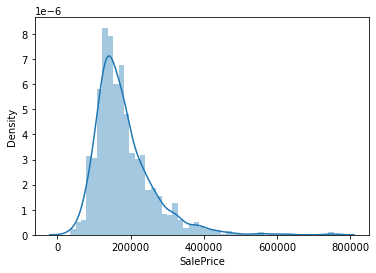

In [10]:
# 売却価格のヒストグラム
sns.distplot(train_df['SalePrice'])
# 売却価格の概要をみてみる
print(train_df["SalePrice"].describe())
print(f"歪度: {round(train_df['SalePrice'].skew(),4)}" )
print(f"尖度: {round(train_df['SalePrice'].kurt(),4)}" )

In [11]:
train_df = train_df[(train_df['LotArea']<20000) & (train_df['SalePrice']<400000)& (train_df['YearBuilt']>1920)]

C:\Users\sibuya yuuki\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


歪度: -0.0987
尖度: 0.3176


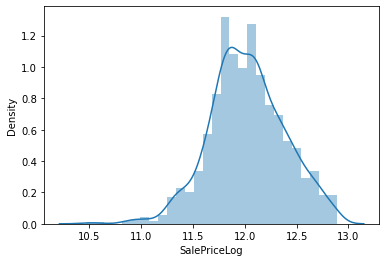

In [12]:
# SalePriceLogに対数変換した値を入れる。説明の都合上新たなカラムを作るが、基本的にそのまま代入して良い。
# np.log()は底がeの対数変換を行う。
train_df['SalePriceLog'] = np.log(train_df['SalePrice'])
# 対数変換後のヒストグラム、歪度、尖度
sns.distplot(train_df['SalePriceLog'])
print(f"歪度: {round(train_df['SalePriceLog'].skew(),4)}" )
print(f"尖度: {round(train_df['SalePriceLog'].kurt(),4)}" )

In [13]:
# 学習データ、説明変数
train_X = train_df.drop(columns = ['SalePrice','SalePriceLog'])
# 学習データ、目的変数
train_y = train_df['SalePriceLog']

# 予測データ、目的変数
test_X = test_df

In [14]:
def lasso_tuning(train_x,train_y):
    # alphaパラメータのリスト
    param_list = [0.001, 0.01, 0.1, 1.0, 10.0,100.0,1000.0] 

    for cnt,alpha in enumerate(param_list):
        # パラメータを設定したラッソ回帰モデル
        lasso = Lasso(alpha=alpha) 
        # パイプライン生成
        pipeline = make_pipeline(StandardScaler(), lasso)

        # 学習データ内でホールドアウト検証のために分割 テストデータの割合は0.3 seed値を0に固定
        X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.3, random_state=0)

        # 学習
        pipeline.fit(X_train,y_train)

        # RMSE(平均誤差)を計算
        train_rmse = np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train)))
        test_rmse = np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test)))
        # ベストパラメータを更新
        if cnt == 0:
            best_score = test_rmse
            best_param = alpha
        elif best_score > test_rmse:
            best_score = test_rmse
            best_param = alpha

    # ベストパラメータのalphaと、そのときのMSEを出力
    print('alpha : ' + str(best_param))
    print('test score is : ' +str(round(best_score,4)))

    # ベストパラメータを返却
    return best_param

# best_alphaにベストパラメータのalphaが渡される。
best_alpha = lasso_tuning(train_X,train_y)

alpha : 0.001
test score is : 0.1071


In [15]:
# ラッソ回帰モデルにベストパラメータを設定
lasso = Lasso(alpha = best_alpha)
# パイプラインの作成
pipeline = make_pipeline(StandardScaler(), lasso)
# 学習
pipeline.fit(train_X,train_y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.001))])

In [16]:
# 結果を予測
pred = pipeline.predict(test_X)

C:\Users\sibuya yuuki\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


歪度: 0.2505
尖度: 1.1631


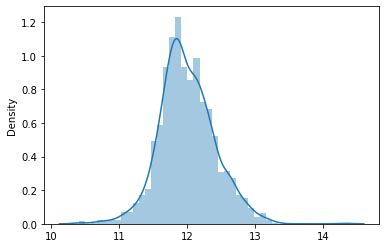

In [17]:
# 予測結果のプロット
sns.distplot(pred)
# 歪度と尖度
print(f"歪度: {round(pd.Series(pred).skew(),4)}" )
print(f"尖度: {round(pd.Series(pred).kurt(),4)}" )

C:\Users\sibuya yuuki\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


歪度: 4.5015
尖度: 58.9749


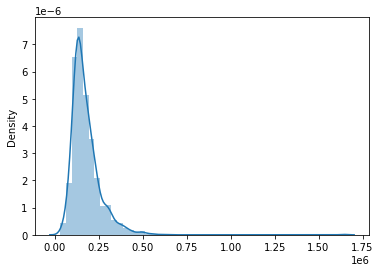

In [18]:
# 指数変換
pred_exp = np.exp(pred)
# 指数変換した予測結果をプロット
sns.distplot(pred_exp)
# 歪度と尖度
print(f"歪度: {round(pd.Series(pred_exp).skew(),4)}" )
print(f"尖度: {round(pd.Series(pred_exp).kurt(),4)}" )

C:\Users\sibuya yuuki\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


歪度: 1.0246
尖度: 0.953


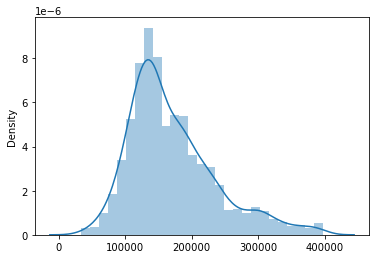

In [19]:
# 400,000より高い物件は除去
pred_exp_ex_outliars = pred_exp[pred_exp<400000]
# 指数変換した予測結果をプロット
sns.distplot(pred_exp_ex_outliars)
# 歪度と尖度
print(f"歪度: {round(pd.Series(pred_exp_ex_outliars).skew(),4)}" )
print(f"尖度: {round(pd.Series(pred_exp_ex_outliars).kurt(),4)}" )

歪度: 0.9457
尖度: 0.7462


C:\Users\sibuya yuuki\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


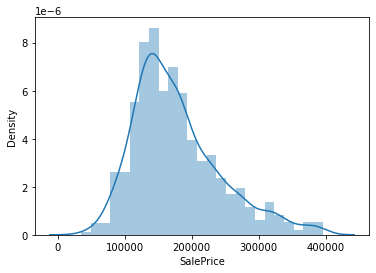

In [20]:
# 学習データの住宅価格をプロット(外れ値除去済み)
sns.distplot(train_df['SalePrice'])
# 歪度と尖度
print(f"歪度: {round(pd.Series(train_df['SalePrice']).skew(),4)}" )
print(f"尖度: {round(pd.Series(train_df['SalePrice']).kurt(),4)}" )

In [ ]:
# sample_submission.csvの読み込み
submission_df = pd.read_csv('sample_submission.csv')
# sample_submission.csvの形式を確認するために先頭五行を見てみる。
submission_df.head()
# 指数変換した値を代入
submission_df['SalePrice'] = pred_exp
# submission.csvを出力
submission_df.to_csv('submission.csv',index=False)